# This section is how to load the data

In [64]:
####### THIS SECTION LOADS THE DATA FROM QUANDL###########3
import pandas as pd
import quandl
import datetime
import numpy as np
from sklearn.model_selection import train_test_split

# We will look at stock prices over the past year
start = datetime.datetime(2003,1,1)
end = datetime.date.today()
#end = datetime.datetime(2013,1,1)

s = ["GOLD_DAILY_USD", "SILVER", "PALL", "REALYIELD"]
y = ["WGC/","LBMA/", "JOHNMATT/", "USTREASURY/"]
stockIndex = pd.DataFrame()

print(type(stockIndex))

for indx, a in enumerate(y):
    dummy = quandl.get(a + s[indx], start_date=start, end_date=end)
    stockIndex = pd.concat([stockIndex, dummy], axis=1, sort=False)

######### This data is not free ###################################
#stockIndex = quandl.get("QRM/WPM", start_date=start, end_date=end)
###################################################################

stockIndex = stockIndex.drop(['GBP', 'EURO', 'Hong Kong 8:30', 'Hong Kong 14:00', 'London 09:00'], axis=1)
stockIndex = stockIndex.dropna()

#print(stockIndex)
#print(stockIndex.corr(method="pearson"))
stockIndex.to_csv("stockIndex.csv")
stockIndex.corr(method="pearson").to_csv("stockCorr.csv")

y = stockIndex.Value
#print(y)
X = stockIndex.drop(['Value'],axis=1)
#print(type(X))

#array_value = stockIndex.values
#print(type(array_value))
#print(array_value)

X_array = X.values
y_array = y.values


<class 'pandas.core.frame.DataFrame'>


# This section is to plot the data

Populating the interactive namespace from numpy and matplotlib


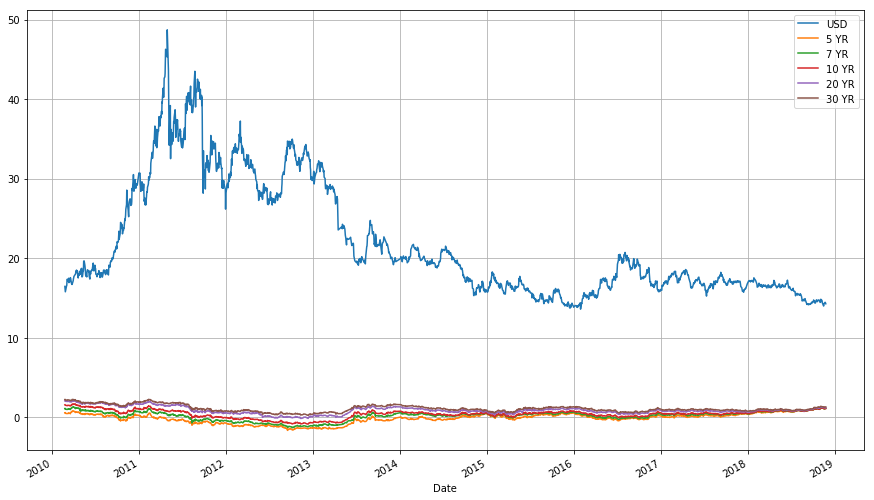

In [65]:
######### THIS SECTION PLOT THE DATA ###########################

import matplotlib.pyplot as plt   # Import matplotlib

# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
#stockIndex["Value"].plot(grid = True) # Plot the adjusted closing price of AAPL
#stockIndex["Adj. High"].plot(grid = True)
#stockIndex["USD"].plot(grid = True)
#stockIndex["New York 9:30"].plot(grid = True)
#LT Real Average (>10Yrs)
#stockIndex["LT Real Average (>10Yrs)"].plot(grid = True)

stockIndex.plot(y=["USD", "5 YR", "7 YR", "10 YR", "20 YR", "30 YR"], grid=True)

In [66]:
#######SPLITTING THE DATA IN 80% FOR TRAINNING SET AND 20% FOR TESTING SET##########

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array,test_size=0.2)
print('This is the X train set')
print(X_train.shape)
print('This is the y train set')
y_train = y_train.reshape((len(y_train), 1))
print(y_train.shape)
print('this is the X test set')
print(X_test.shape)
print('this is the y test set')
y_test = y_test.reshape((len(y_test), 1))
print(y_test.shape)


This is the X train set
(1592, 7)
This is the y train set
(1592, 1)
this is the X test set
(399, 7)
this is the y test set
(399, 1)


In [80]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from IPython.core.debugger import set_trace

In [81]:
train_set = list(zip(X_train, y_train))
test_set = list(zip(X_test, y_test))
#print(train_set)
#print(test_set)

batch_size = 10

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                         batch_size=batch_size,
                                         shuffle=True)


test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                         batch_size=batch_size,
                                         shuffle=False)


In [112]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(7, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 1)
        
    def forward(self, x):
        
        #x = np.asarray(x)
        #print(x)
        x = x.view(-1, 7)
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1))
        x3 = self.fc3(x2)
        #return F.log_softmax(x3,1)
        #print(x3)
        return x3
    
    def name(self):
        return "MLP"

In [128]:
model = MLP()

optimizer = optim.SGD(model.parameters(), lr=0.01)

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

for epoch in range(20):
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x = x.float()
        target = target.float()
        out = model(x)
        loss = criterion(out, target)
        #_, pred_label = torch.max(out.data, 1)
        pred_label,_ = torch.max(out.data, 1)
        #pred_label = pred_label.float()
        total_cnt += x.shape[0]
        print(out.data)
        print(target)
        #correct_cnt+= (pred_label == target).sum().item()
        correct_cnt+= (math.isclose(out.data, target,rel_tol=1e-5)).sum().item()
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, correct_cnt*1.0/total_cnt))
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        x = x.float()
        target = target.float()
        out = model(x)
        loss = criterion(out, target)
        #_, pred_label = torch.max(out.data, 1)
        pred_label,_ = torch.max(out.data, 1)
        #pred_label = pred_label.float()
        total_cnt += x.shape[0]
        #print(target.data)
        correct_cnt += (pred_label == target).sum().item()
        #correct_cnt+= (math.isclose(pred_label, target,rel_tol=1e-5)).sum().item()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt))

tensor([[37.2617],
        [21.6645],
        [27.5171],
        [27.4210],
        [16.2388],
        [25.0598],
        [18.6931],
        [24.6134],
        [16.8975],
        [24.8760]])
tensor([[1319.7500],
        [1644.0000],
        [1162.0000],
        [1226.5000],
        [1256.0000],
        [1324.1500],
        [1139.5000],
        [1690.5000],
        [1114.0000],
        [1375.2500]])


ValueError: only one element tensors can be converted to Python scalars